In [1]:
import pandas as pd
import numpy as np
import csv
import random
import ast

from scipy import stats, integrate
import matplotlib.pyplot as plt
import re
import nltk
from nltk.probability import FreqDist

import seaborn as sns
sns.set(color_codes=True)

import scrapeMyProf as smp
%load_ext autoreload
%autoreload 2

%matplotlib inline

Immediate things to do
* Scraping: Scrape reviewer id as well
looks like <tr id="27765702" class = "">
* Scrape additional states

Ultimate goals
* Create a recommendation engine. Let user input liked & disliked professors, and create a recommendation engine (across university, in specific department).
* Look up a professor, predict average overall/difficulty based on department/gender/school. Get the deviation from that amount. Extract important sentences or words. Purpose: evaluate individual teaching in the correct playing field.
* Same for schools, deviations could give information to schools, prospective students.

Possible things to do
* Clustering of department names to group departments
* Difficulty vs Overall for men vs. women (linear regression)
* Consider the gender of reviewer (would need to predict reviewer gender)

# Setup for Multiple States, include School & State

The data will need some cleaning up and the addition of gender and number of pronouns corresponding to that gender. Eliminate any professors that are unknown. Add the name city state of school. This takes a while, so if it has already been done, simply load the data, filename for state with '_cleanGender.csv' at the end.

In [273]:
# Pull in RI profs, clean up, add gender and number of pronouns
review_df = smp.cleanAddGender_csv('../smp_data/RI_profs_021717',colHeader)

In [275]:
# Pull in NH profs
NH_df = smp.cleanAddGender_csv('../smp_data/NH_profs_021917',colHeader)

# Pull in ME profs
ME_df = smp.cleanAddGender_csv('../smp_data/ME_profs_022117',colHeader)

In [276]:
# Combine all states
review_df = review_df.append(NH_df,ignore_index=True).append(ME_df,ignore_index=True)

In [386]:
# Some initial combining of department names -- need to do this more systematically and automatically
review_df.replace({'department':{'Behavioral Science':'Psychology','Art & Art History':'Art','Art & Visual Culture':'Art','Art History':'Art','New Media Art':'Art','Computer & Informational Tech.':'Computing','Computer Science':'Computing','Physical Education':'Physical Ed','Legal Studies':'Law'}},inplace=True)

In [ ]:
# This is a professor review of self that accidentally stayed in
review_df = review_df.drop(review_df.index[159564])

In [399]:
# Exporting to csv if not done yet
review_df.to_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8', header=True, index=False)

In [2]:
# Importing clean data 
review_df = pd.read_csv('../smp_data/ME_NH_RI_reviews.csv', encoding='utf-8',low_memory=False)

# Basic Setup

In [9]:
# Current colHeader 
colHeader =  ['index', 'profID', 'profname', 'gender', 'schoolID', 'department',
       'class', 'date', 'difficulty', 'overall', 'grade', 'textInfo',
       'accessible', 'amazing', 'caring', 'criteria', 'extra', 'feedback',
       'few', 'group', 'hilarious', 'homework', 'inspirational', 'lecture',
       'papers', 'participation', 'quiz', 'read', 'respected', 'skip', 'test',
       'tough', 'cleanText', 'genderBest', 'selfPronCnt', 'schoolname_s',
       'schoolcity_s', 'schoolstate_s']

In [3]:
# Group by prof for all
groupProf_df = smp.groupProf_df(review_df,'../smp_data/ME_NH_RI_reviews')

In [295]:
# Group by prof and year
yearProf_df = smp.yearProf_df(review_df,'../smp_data/ME_NH_RI_reviews')

In [296]:
# this gives total numbers of reviews
review_df['genderBest'].value_counts()

male      107930
female     64799
Name: genderBest, dtype: int64

In [297]:
# how do difficulty and overall rating compare by gender?
# note here that they are pretty close to identical in mean
groupProf_df[['genderBest','overall','difficulty']].groupby('genderBest').mean()

,overall,difficulty
genderBest,,
female,3.712961,2.912544
male,3.754707,2.903113


In [298]:
# standard deviation by gender
groupProf_df[['genderBest','overall','difficulty']].groupby('genderBest').std()

,overall,difficulty
genderBest,,
female,1.087274,0.932829
male,1.024808,0.925470


In [323]:
review_df.describe()

,index,profID,schoolID,difficulty,overall,accessible,amazing,caring,criteria,extra,...,papers,participation,quiz,read,respected,skip,test,tough,selfPronCnt,year
count,172728.000000,1.727280e+05,172728.000000,172721.000000,172721.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,...,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000,172728.000000
mean,31241.563962,6.014614e+05,1313.627987,3.010358,3.638017,0.004933,0.014039,0.025815,0.017357,0.008869,...,0.004892,0.023447,0.004226,0.021189,0.027737,0.024814,0.002275,0.035206,1.958843,2008.384269
std,20554.089267,5.513438e+05,1512.874384,1.264248,1.432688,0.070059,0.117654,0.158584,0.130597,0.093759,...,0.069772,0.151320,0.064873,0.144016,0.164220,0.155557,0.047645,0.184300,1.905021,4.102278
min,0.000000,8.400000e+02,41.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2001.000000
25%,14409.000000,1.673990e+05,667.000000,2.000000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000
50%,28859.500000,3.929060e+05,1122.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2008.000000
75%,44486.000000,9.167402e+05,1266.000000,4.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2012.000000
max,80283.000000,2.233464e+06,15648.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,2017.000000


# Women Have Fewer Reviews

In [300]:
# women have fewer reviews per prof -- why is that? looking to see how persistant
# avg reviewcount for women vs. men
# what explains this
groupProf_df[['genderBest','reviewcount']].groupby('genderBest').mean()

,reviewcount
genderBest,
female,9.152401
male,12.346145


In [301]:
# could this be related to length of time available to review
# first total reviews by year

#note that RMP declined in use pretty steadily since 2004 and it's high points were 2001 and 2003
yearProf_df[['genderBest','year','reviewcount']].groupby(['year']).mean()

,reviewcount
year,
2001,6.343537
2002,3.814220
2003,5.377598
2004,4.461247
2005,4.343967
2006,2.763740
2007,2.468324
2008,2.557429
2009,2.355807


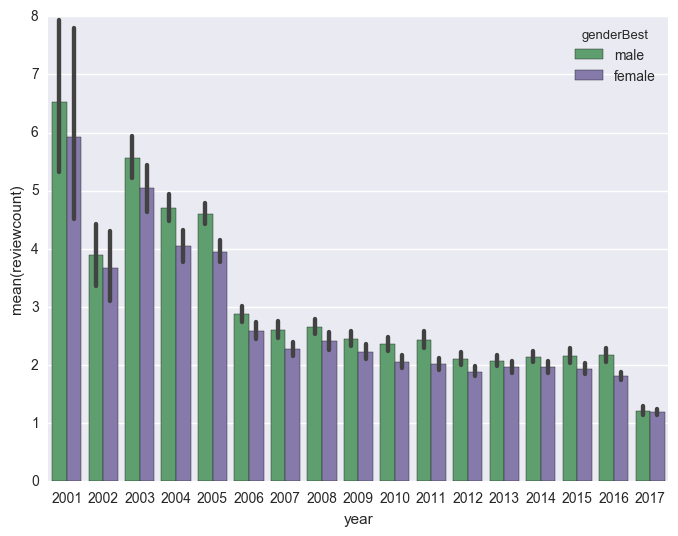

In [303]:
size=(8, 6))
sns.barplot(x="year", y="reviewcount", hue = "genderBest", data=yearProf_df,
              palette={"male": "g", "female": "m"});

# Impact of Grade on Ratings

In [311]:
# Get rid of grade value oddities
review_df.replace({'grade':{'Grade':'Unknown','yet':'none yet',450:'Unknown'}},inplace=True)

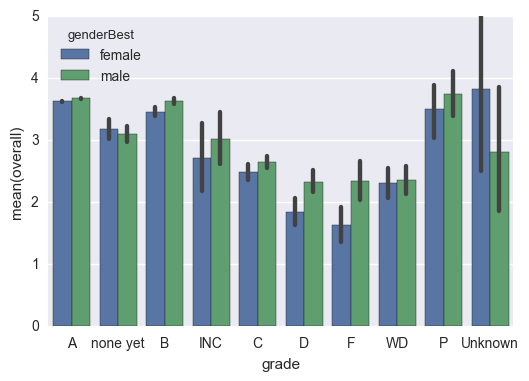

In [321]:
# low grades are correlated with low overall rating, but bad grades seem to hit female teachers more
sns.barplot(x="grade", y="overall", hue = 'genderBest',data=review_df);

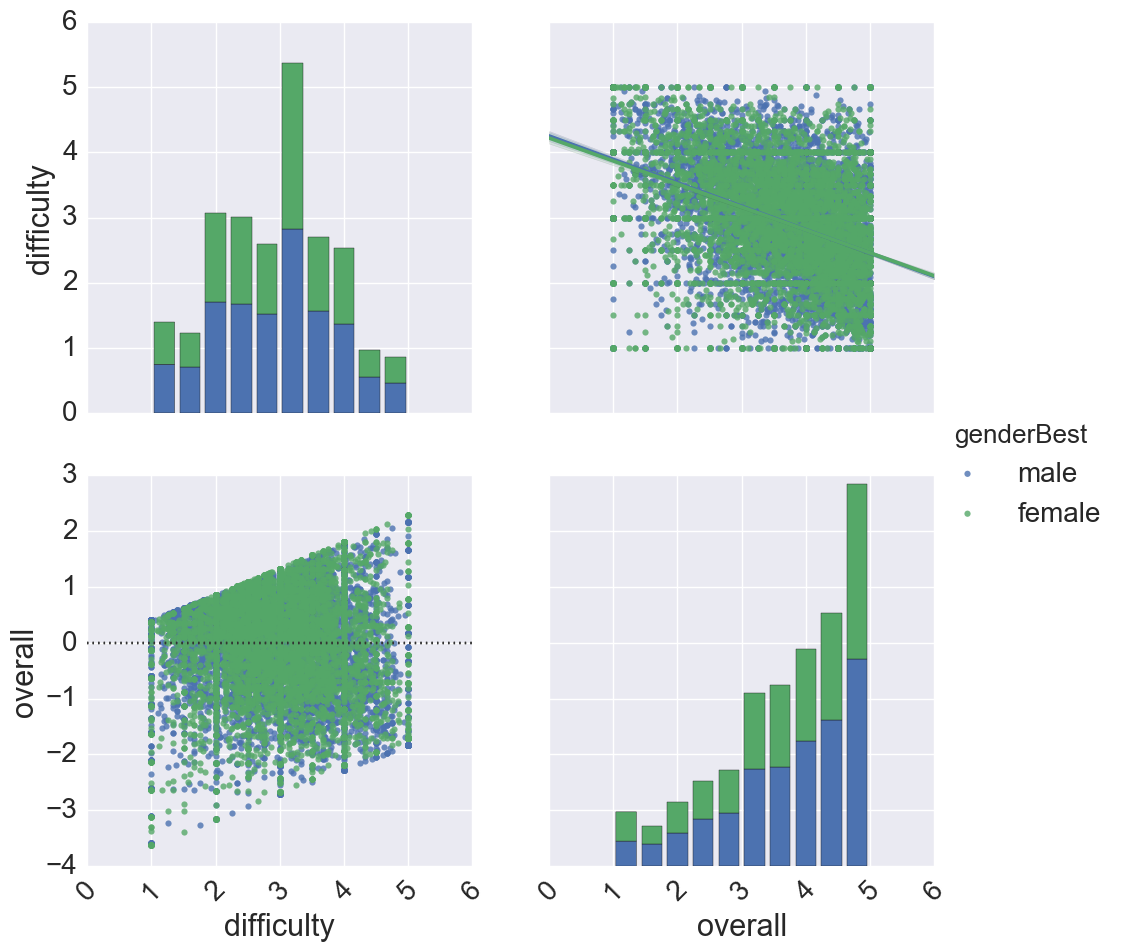

In [28]:
# Difficulty vs Overall for men & women
#sns.jointplot(x='difficulty',y='overall', hue='genderBest',data=groupProf_df);
#g = sns.pairplot(groupProf_df, size=3,vars=["difficulty", "overall"], hue='genderBest')
#g.set(alpha=0.9)

g = sns.PairGrid(groupProf_df[["difficulty", "overall","genderBest"]], size =5,hue="genderBest")  
sns.set(font_scale=2)
g.map_upper(sns.regplot)  
g.map_lower(sns.residplot)  
g.map_diag(plt.hist)  
g.set(alpha=0.001)  

# Looking across multiple years at overall and difficulty

In [11]:
years = yearProfMF_df[['genderBest','year','overall','difficulty']].groupby(['genderBest','year']).mean()

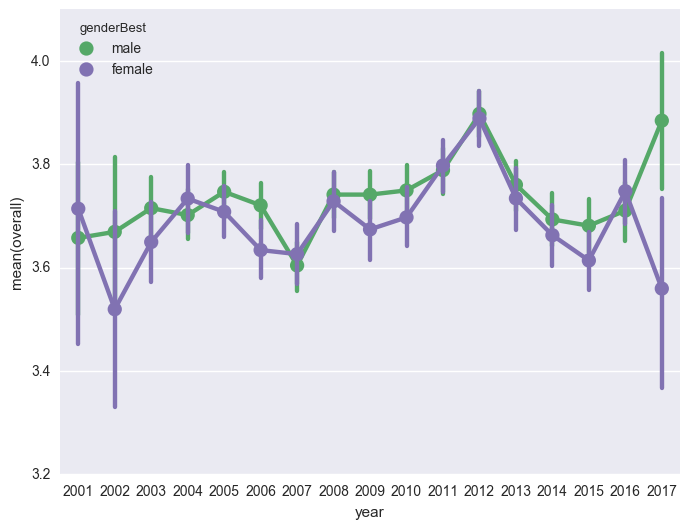

In [325]:
plt.figure(figsize=(8, 6))
sns.pointplot(x="year", y="overall", hue = "genderBest", data=yearProf_df,
              palette={"male": "g", "female": "m"});

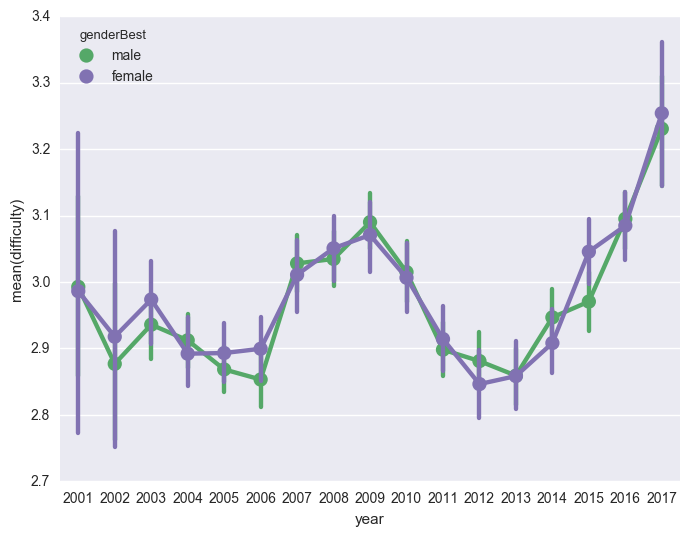

In [326]:
plt.figure(figsize=(8, 6))
sns.pointplot(x="year", y="difficulty", hue = "genderBest", data=yearProf_df,
              palette={"male": "g", "female": "m"});

# Distribution of overall

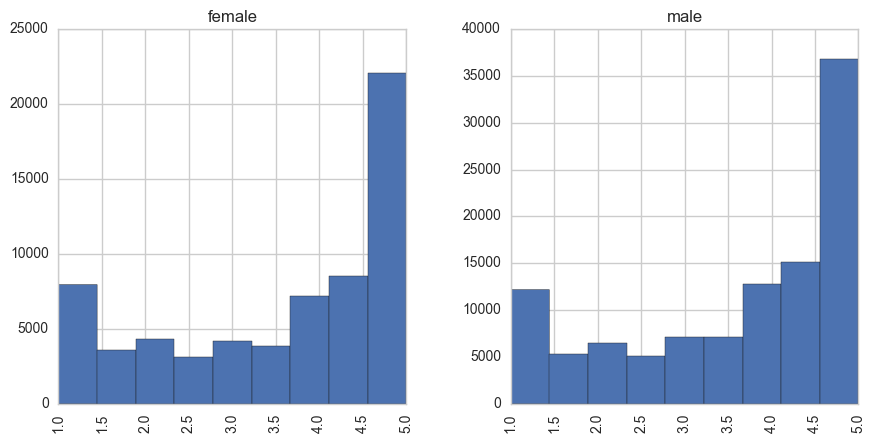

In [417]:
plt.rcParams["figure.figsize"] = [10,5]
plt.figure()
review_df.hist(by='genderBest',column = 'overall',bins = 9)
plt.show()

# Overall and Difficulty by Department

In [387]:
#grab all of the fields, do the overall (not by gender), include counts of all
dept_df = review_df[['department','genderBest','overall','difficulty']].groupby(['department','genderBest']).mean().unstack()
dept_df = pd.DataFrame(dept_df.to_records())
cnt_df = review_df[['department','genderBest','amazing']].groupby(['department','genderBest']).count().unstack()
cnt_df = pd.DataFrame(cnt_df.to_records())
allDept_df =review_df[['department','overall','difficulty','amazing']].groupby(['department']).agg({'overall' : 'mean','difficulty':'mean','amazing':'count'}).reset_index()

dept_df = pd.merge(dept_df, cnt_df, on='department')
dept_df.rename(columns = {"('overall', 'female')":'overallFemale',"('overall', 'male')":'overallMale',"('difficulty', 'female')":'difficultyFemale',"('difficulty', 'male')":'difficultyMale',"('amazing', 'female')":'countFemale',"('amazing', 'male')":'countMale'},inplace=True)
dept_df = pd.merge(dept_df,allDept_df,on='department')
dept_df.rename(columns = {'overall':'overallMF','difficulty':'difficultyMF','amazing':'countMF'},inplace=True) 

In [388]:
#drop NAs and anything having fewer than 20 prof
deptClean = dept_df.dropna().reset_index()
deptClean.drop(deptClean[deptClean.countFemale<30].index,inplace=True)
deptClean.drop(deptClean[deptClean.countMale<30].index,inplace=True)


In [389]:
#columns to compare male/female
deptClean['overallDiff']=deptClean['overallFemale']-deptClean['overallMale']
deptClean['difficultyDiff']=deptClean['difficultyFemale']-deptClean['difficultyMale']
deptClean['countRatioFM']=(deptClean['countFemale']-deptClean['countMale'])/(deptClean['countFemale']+deptClean['countMale'])


In [390]:
#difficulty vs overall
deptClean['doRatioAll'] = deptClean['overallMF']/deptClean['difficultyMF']
deptClean['doRatioMale'] = deptClean['overallMale']/deptClean['difficultyMale']
deptClean['doRatioFemale'] = deptClean['overallFemale']/deptClean['difficultyFemale']


In [358]:
cols = ['index', 'department', 'overallFemale', 'overallMale', 'overallDiff',
       'difficultyFemale', 'difficultyMale', 'difficultyDiff','doRatioAll','doRatioFemale','doRatioMale','countFemale', 'countMale',
       'overallMF', 'difficultyMF', 'countMF','countRatioFM']

In [391]:
deptClean = deptClean[cols]

Difficulty and overall are well correlated. Note for women the scores are in a narrower band.

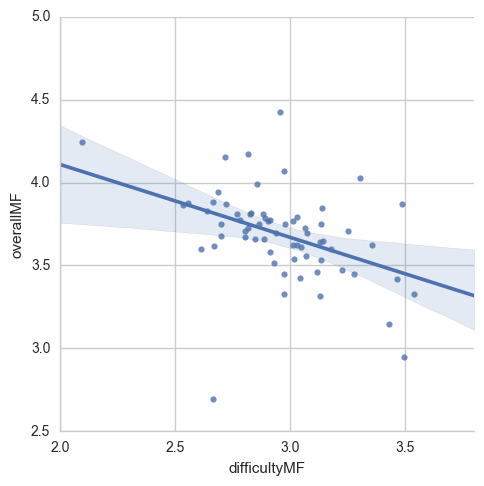

In [392]:
sns.lmplot(x='difficultyMF',y='overallMF',data=deptClean);

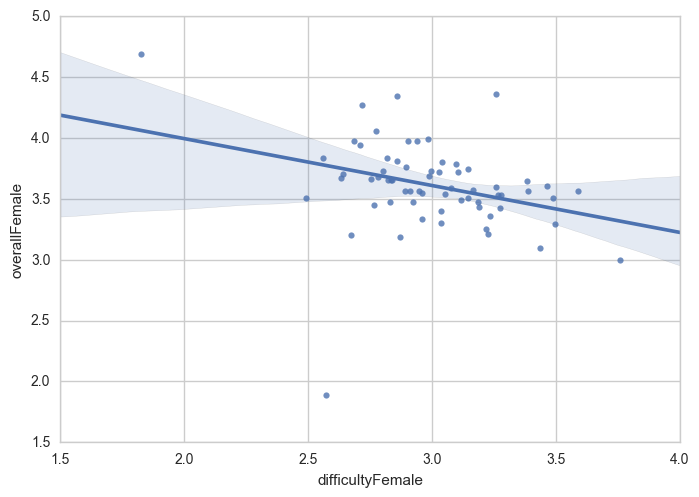

In [393]:
sns.regplot(x="difficultyFemale", y="overallFemale", data=deptClean);

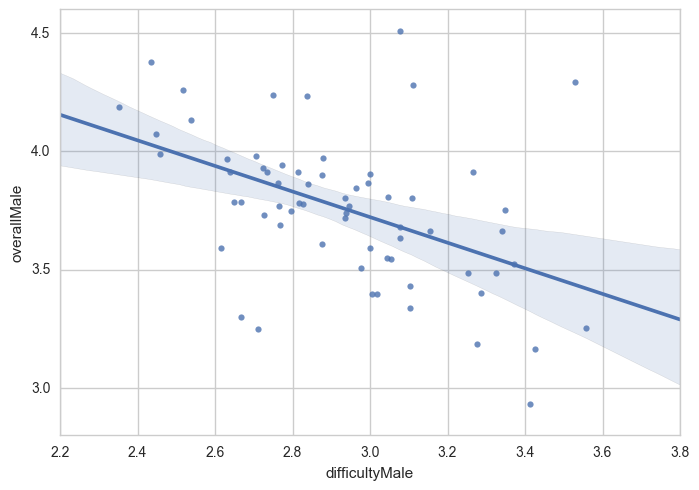

In [394]:
sns.regplot(x="difficultyMale", y="overallMale", data=deptClean);

In [ ]:
#What about male vs female scores by department, try a scatterplot

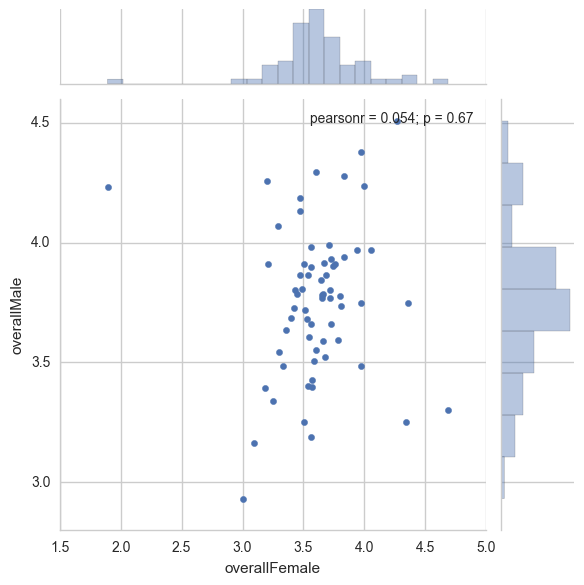

In [395]:
sns.jointplot(x="overallFemale", y="overallMale", data=deptClean);

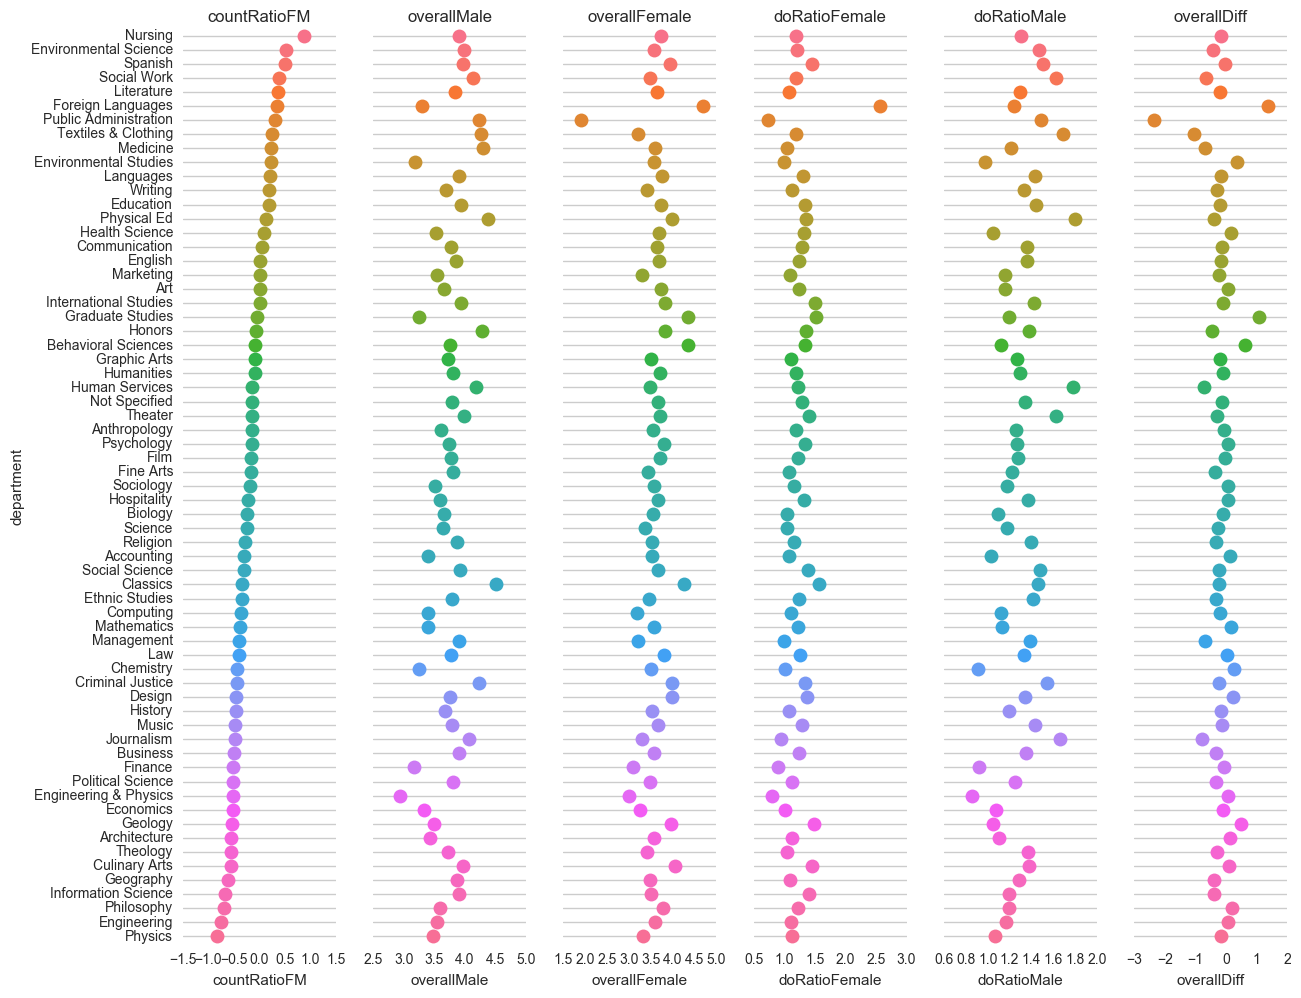

In [398]:
sns.set(style="whitegrid")

# Make the PairGrid
g = sns.PairGrid(deptClean.sort_values("countRatioFM", ascending=False),
                 x_vars=['countRatioFM','overallMale','overallFemale','doRatioFemale','doRatioMale','overallDiff'], y_vars=["department"],
                 size=10, aspect=.2)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="husl", edgecolor="gray")

## Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# Use semantically meaningful titles for the columns
titles =['countRatioFM','overallMale','overallFemale','doRatioFemale','doRatioMale','overallDiff']

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


# Review Text

In [175]:
review_df['wordcount']=review_df['cleanText'].apply(len)

In [176]:
#lexical diversity for each review
def lexDiversity(text):
    if len(text)==0:
        ld = 0
    else:
        ld = len(text)/len(set(text))
    return ld
review_df['lexDiversity']=review_df['cleanText'].apply(lexDiversity)

In [39]:
review_df[['genderBest','femPronCnt','malPronCnt','overall','difficulty']].groupby('genderBest').mean()

,femPronCnt,malPronCnt,overall,difficulty
genderBest,,,,
female,2.229251,0.006009,3.555939,3.003994
male,0.012738,2.014684,3.640443,2.926441
unknown,0.286885,1.049180,3.991803,2.696721


In [29]:
overallF = review_df[['overall','difficulty','wordcount','lexDiversity']][review_df['genderBest']=='female'].groupby('overall').mean()

In [30]:
overallM = review_df[['overall','difficulty','wordcount','lexDiversity']][review_df['genderBest']=='male'].groupby('overall').mean()

In [31]:
overallF

,difficulty,wordcount,lexDiversity
overall,,,
1.0,4.071200,181.730667,7.969083
1.5,3.733133,203.593373,8.762809
2.0,3.544028,201.594130,8.701253
2.5,3.377139,205.362081,8.807440
3.0,3.119261,195.989022,8.462665
3.5,2.943386,215.292601,9.166490
4.0,2.766460,196.766165,8.466450
4.5,2.761775,194.698339,8.383879
5.0,2.456544,183.010942,7.958974


In [32]:
overallM

,difficulty,wordcount,lexDiversity
overall,,,
1.0,4.140419,181.371916,7.921566
1.5,3.814076,200.882832,8.626886
2.0,3.550495,203.036304,8.691842
2.5,3.350692,206.729455,8.831341
3.0,3.081399,198.239897,8.514508
3.5,2.810779,207.175747,8.824980
4.0,2.678801,192.421512,8.275893
4.5,2.652211,194.279581,8.354833
5.0,2.397270,174.310563,7.613932


In [176]:
keywords = list({
    'tough':'Tough Grader','feedback':'Gives good feedback','respected':'Respected','read':'Get ready to read',
    'participation':'Participation matters','skip':'Skip class? You won\'t pass.','homework':'LOTS OF HOMEWORK',
    'inspirational':'Inspirational','quiz':'BEWARE OF POP QUIZZES','accessible':'ACCESSIBLE OUTSIDE CLASS',
    'papers':'SO MANY PAPERS','criteria':'Clear grading criteria','hilarious':'Hilarious',
    'test':'TEST HEAVY','few':'GRADED BY FEW THINGS','amazing':'Amazing lectures','caring':'Caring',
    'extra':'EXTRA CREDIT','group':'GROUP PROJECTS','lecture':'LECTURE HEAVY'
    }.keys())

# fillna on just the keyword columns
review_df[keywords] = review_df[keywords].fillna(0)

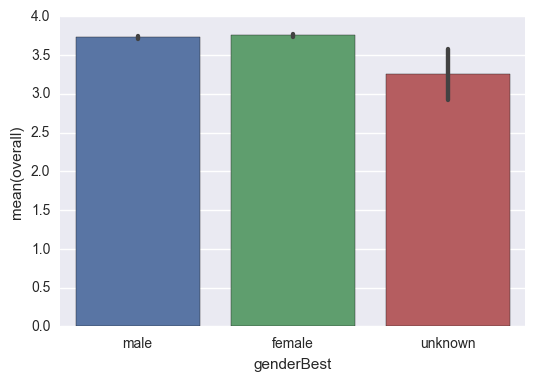

In [105]:
#overall scores by gender
sns.barplot(x="genderBest", y="overall", data=review_df);

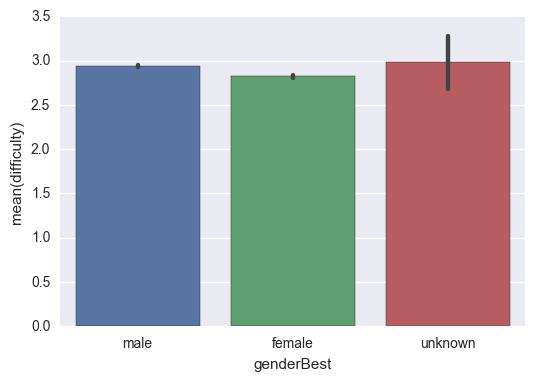

In [64]:
#gender scores by prof
sns.barplot(x="genderBest", y="difficulty", data=review_df);

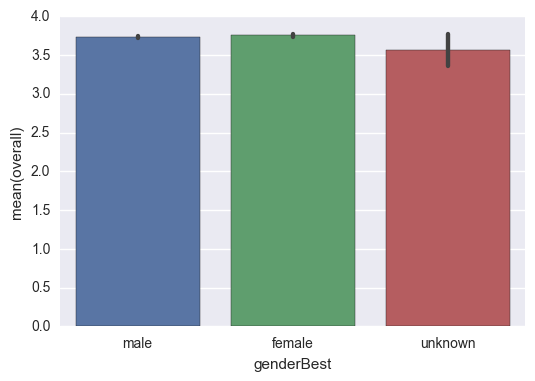

In [182]:
sns.barplot(x="genderBest", y="overall", data=review_df);

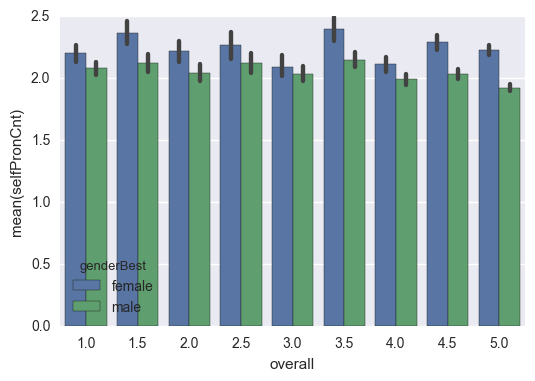

In [104]:
# Average pronoun use by Gender and rating
sns.barplot(x="overall", y='overall', hue = "genderBest", data=reviewMF_df);


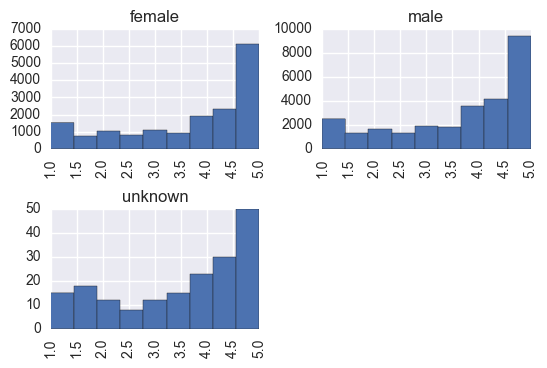

In [15]:
review_df.hist(by='genderBest',column = 'overall',bins = 9)
plt.show()

In [105]:
def content(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [word for word in text if word.lower() not in stopwords]
    return content

def content_fraction(text):
    contents = content(text)
    return len(contents)/len(text)

In [106]:
genderText = review_df[['genderBest','cleanText']].groupby('genderBest').sum().reset_index()


In [107]:
genderText

,genderBest,cleanText
0,female,this is a very challenging class the inclass e...
1,male,he was a great guy and made the class better h...


In [181]:
deptText = review_df[['department','genderBest']].groupby('department').count().reset_index()

In [183]:
# Looking for departments that have a lot of faculty
# Here are the ones with just a few to trim
deptText[deptText['genderBest']<30]

,department,genderBest
0,Academic Learning Skills,2
2,Advertising,2
3,African-American Studies,11
4,Africana Studies,1
9,Art Art History,2
12,Astronomy,6
15,Business Law,12
18,Chinese,24
19,Civilization,7
25,Computer Skills,14


In [ ]:
deptTokenize = nltk.word_tokenize(genderText['cleanText'][0])
femaleContent = content(femaleTokenize)
femaleDist = FreqDist(femaleContent)
femaleVocab = list(femaleDist.keys())

In [110]:
femaleTokenize = nltk.word_tokenize(genderText['cleanText'][0])
femaleContent = content(femaleTokenize)
femaleDist = FreqDist(femaleContent)
femaleVocab = list(femaleDist.keys())

In [ ]:
femaleDist.most_common(50)

In [ ]:
maleContent = content(maleTokenize)
maleDist = FreqDist(maleContent)
maleVocab = list(maleDist.keys())

In [ ]:
maleDist.most_common(50)

Can continue this to make some graphs of word frequency

## Get features from the department field (treating as text), plus gender

In [184]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [ ]:
# XXXXXX do this all with groupProf_df
#####

In [185]:
def tokenize_and_stem(text):
    tokens = nltk.word_tokenize(text)
    stems = [stemmer.stem(t) for t in tokens]
    return stems

In [ ]:
def dept_features(department,gender,word_features):
    review_words = set(review)
    features={}
    for word in word_features:
        features['contains(%s)' % word] = (word in review_words)
        features['gender'] = gender
    return features

## Bag of Words and RandomForest to predict gender from text of review

In [175]:
from sklearn.feature_extraction.text import CountVectorizer

train_set = groupProf_df
test_set = train_set.sample(frac=.5)
train_set=train_set.drop(test_set.index)

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 5000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features = vectorizer.fit_transform(train_set['cleanText'])

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()


In [176]:
vocab = vectorizer.get_feature_names()

In [178]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 150) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( train_data_features, train_set["genderBest"] )


In [172]:
# Get a bag of words for the test set, and convert to a numpy array
test_data_features = vectorizer.fit_transform(test_set['cleanText'])
test_data_features = test_data_features.toarray()

# Use the random forest to make sentiment label predictions
result = forest.predict(test_data_features)

# Copy the results to a pandas dataframe with an "id" column and
# a "sentiment" column
output = pd.DataFrame( data={"profID":test_set["profID"], "genderPredict":result} )

In [173]:
prediction = pd.merge(output,test_set[['profID','genderBest']],on='profID',how='inner')

In [174]:
len(prediction[prediction['genderBest']==prediction['genderPredict']])/len(prediction)

0.5524924471299094

# Predicting overall from review text and gender

In [57]:
allTokenize = nltk.word_tokenize(review_df['cleanText'].sum())

In [58]:
allContent = content(allTokenize)

In [69]:
allDist = FreqDist(allContent)
allFeatures = list(allDist.keys())[:500]

In [39]:
def review_features(review,gender,word_features):
    review_words = set(review)
    features={}
    for word in word_features:
        features['contains(%s)' % word] = (word in review_words)
        features['gender'] = gender
    return features

In [74]:
shortReview = review_df[['cleanText','genderBest','overall']]

In [75]:
reviews = [(review_features(shortReview['cleanText'][i],shortReview['genderBest'][i],allFeatures),shortReview['overall'][i]) for i in range(len(shortReview))]

In [80]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [82]:
print(nltk.classify.accuracy(classifier,test_set))

0.351976943169


In [83]:
classifier.show_most_informative_features(20)

Most Informative Features
                  gender = 'unknown'         1.5 : 2.5    =      4.3 : 1.0
             contains(x) = True              nan : 1.0    =      2.5 : 1.0
             contains(x) = False             nan : 3.5    =      1.2 : 1.0
                  gender = 'female'          2.5 : 3.5    =      1.2 : 1.0
                  gender = 'male'            3.5 : nan    =      1.1 : 1.0
     contains(attracted) = False             nan : 3.5    =      1.0 : 1.0
        contains(fsuand) = False             nan : 3.5    =      1.0 : 1.0
 contains(discriminated) = False             nan : 3.5    =      1.0 : 1.0
        contains(gamble) = False             nan : 3.5    =      1.0 : 1.0
      contains(basement) = False             nan : 3.5    =      1.0 : 1.0
          contains(bunn) = False             nan : 3.5    =      1.0 : 1.0
       contains(whnever) = False             nan : 3.5    =      1.0 : 1.0
        contains(becaus) = False             nan : 3.5    =      1.0 : 1.0

In [47]:
shortReview.apply(lambda x,y:review_features(x,y,allFeatures))

TypeError: ("<lambda>() missing 1 required positional argument: 'y'", 'occurred at index cleanText')

In [167]:

# Compute the correlation matrix
corr = review_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
Back to top 


AttributeError: module 'seaborn' has no attribute 'corrplot'

In [253]:
aggList=dict(zip(keywords,['sum']*len(keywords)))
aggList['genderBest']='count'
aggList

{'accessible': 'sum',
 'amazing': 'sum',
 'caring': 'sum',
 'criteria': 'sum',
 'extra': 'sum',
 'feedback': 'sum',
 'few': 'sum',
 'genderBest': 'count',
 'group': 'sum',
 'hilarious': 'sum',
 'homework': 'sum',
 'inspirational': 'sum',
 'lecture': 'sum',
 'papers': 'sum',
 'participation': 'sum',
 'quiz': 'sum',
 'read': 'sum',
 'respected': 'sum',
 'skip': 'sum',
 'test': 'sum',
 'tough': 'sum'}

In [152]:
# Plot distribution of overall and difficulty against tags
# This function draws a grid of histograms
# numVar is the numeric variable to plot
# variables is a list of indicator variables
def draw_histograms_indic(df, numVar,variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,16))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[numVar][df[var_name]==1].hist(bins=8,ax=ax)
        ax.set_title(var_name+" Distribution")
    # fig.tight_layout()  # Improves appearance a bit.
    plt.show()

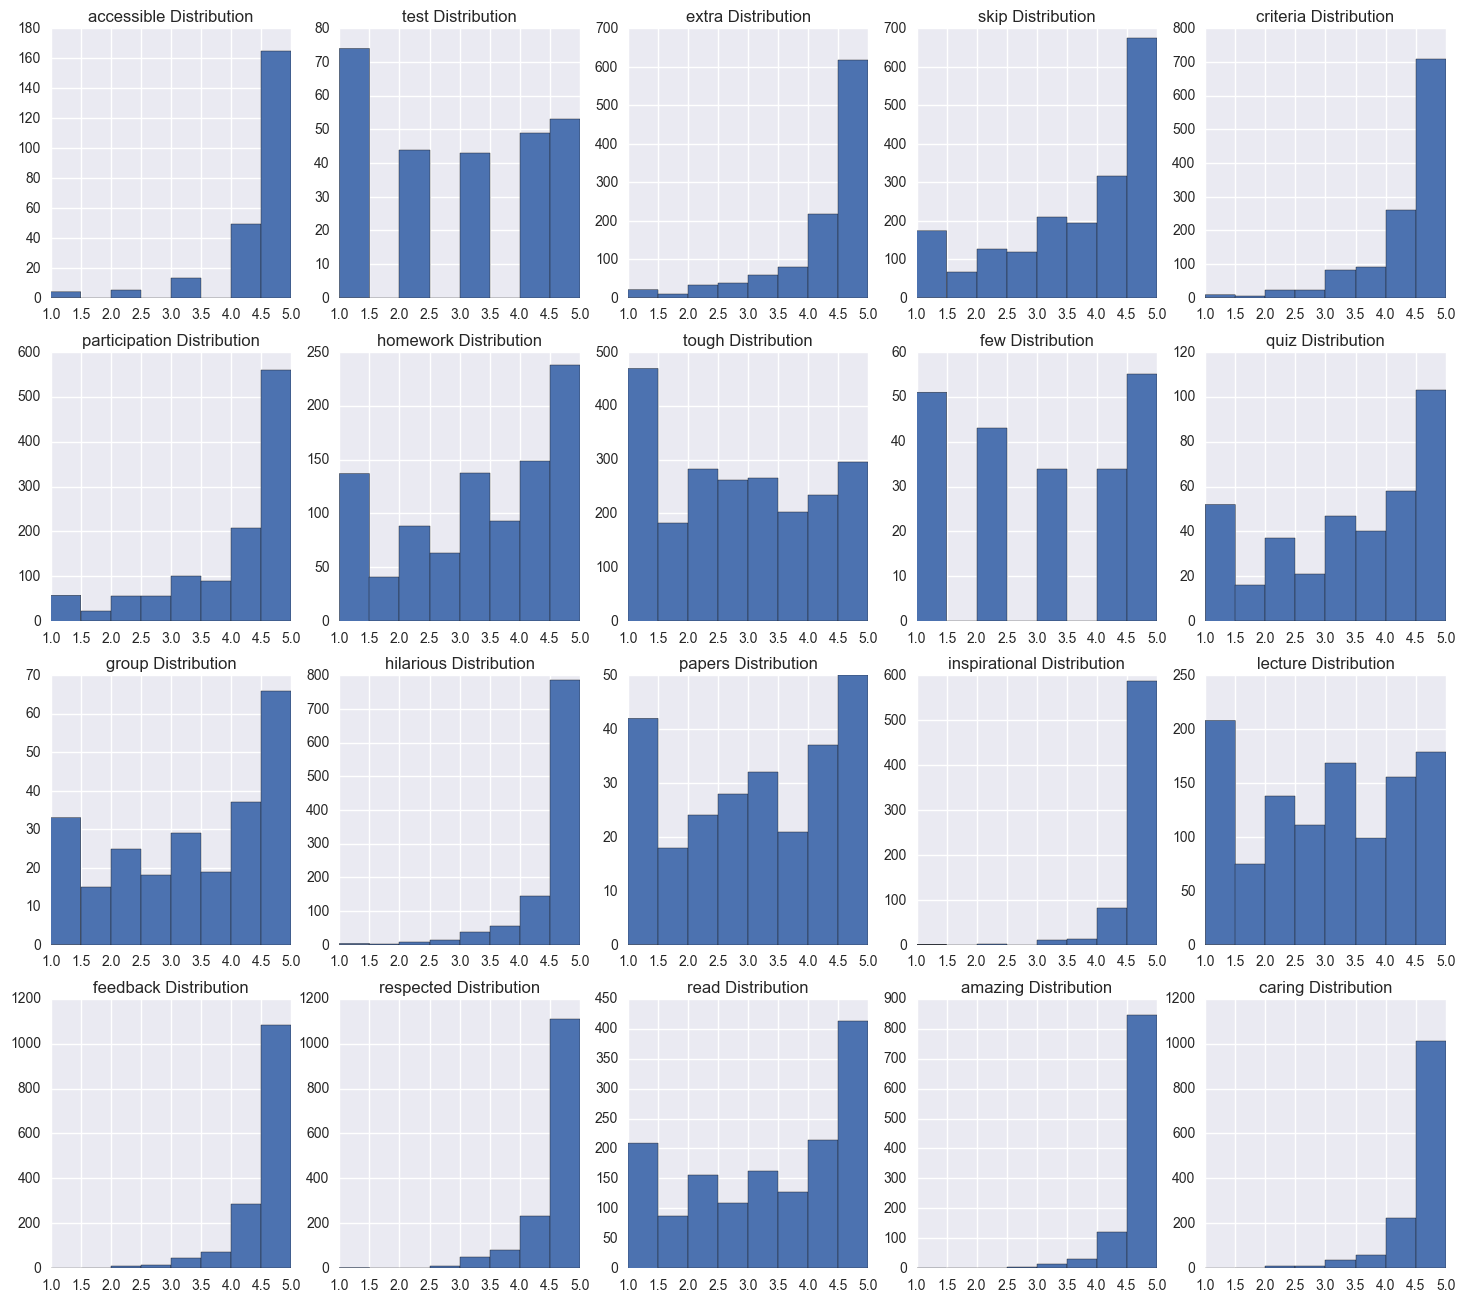

In [150]:
# hist of 'overall' split up by the various tags
draw_histograms_indic(review_df, 'overall',keywords, 4, 5)


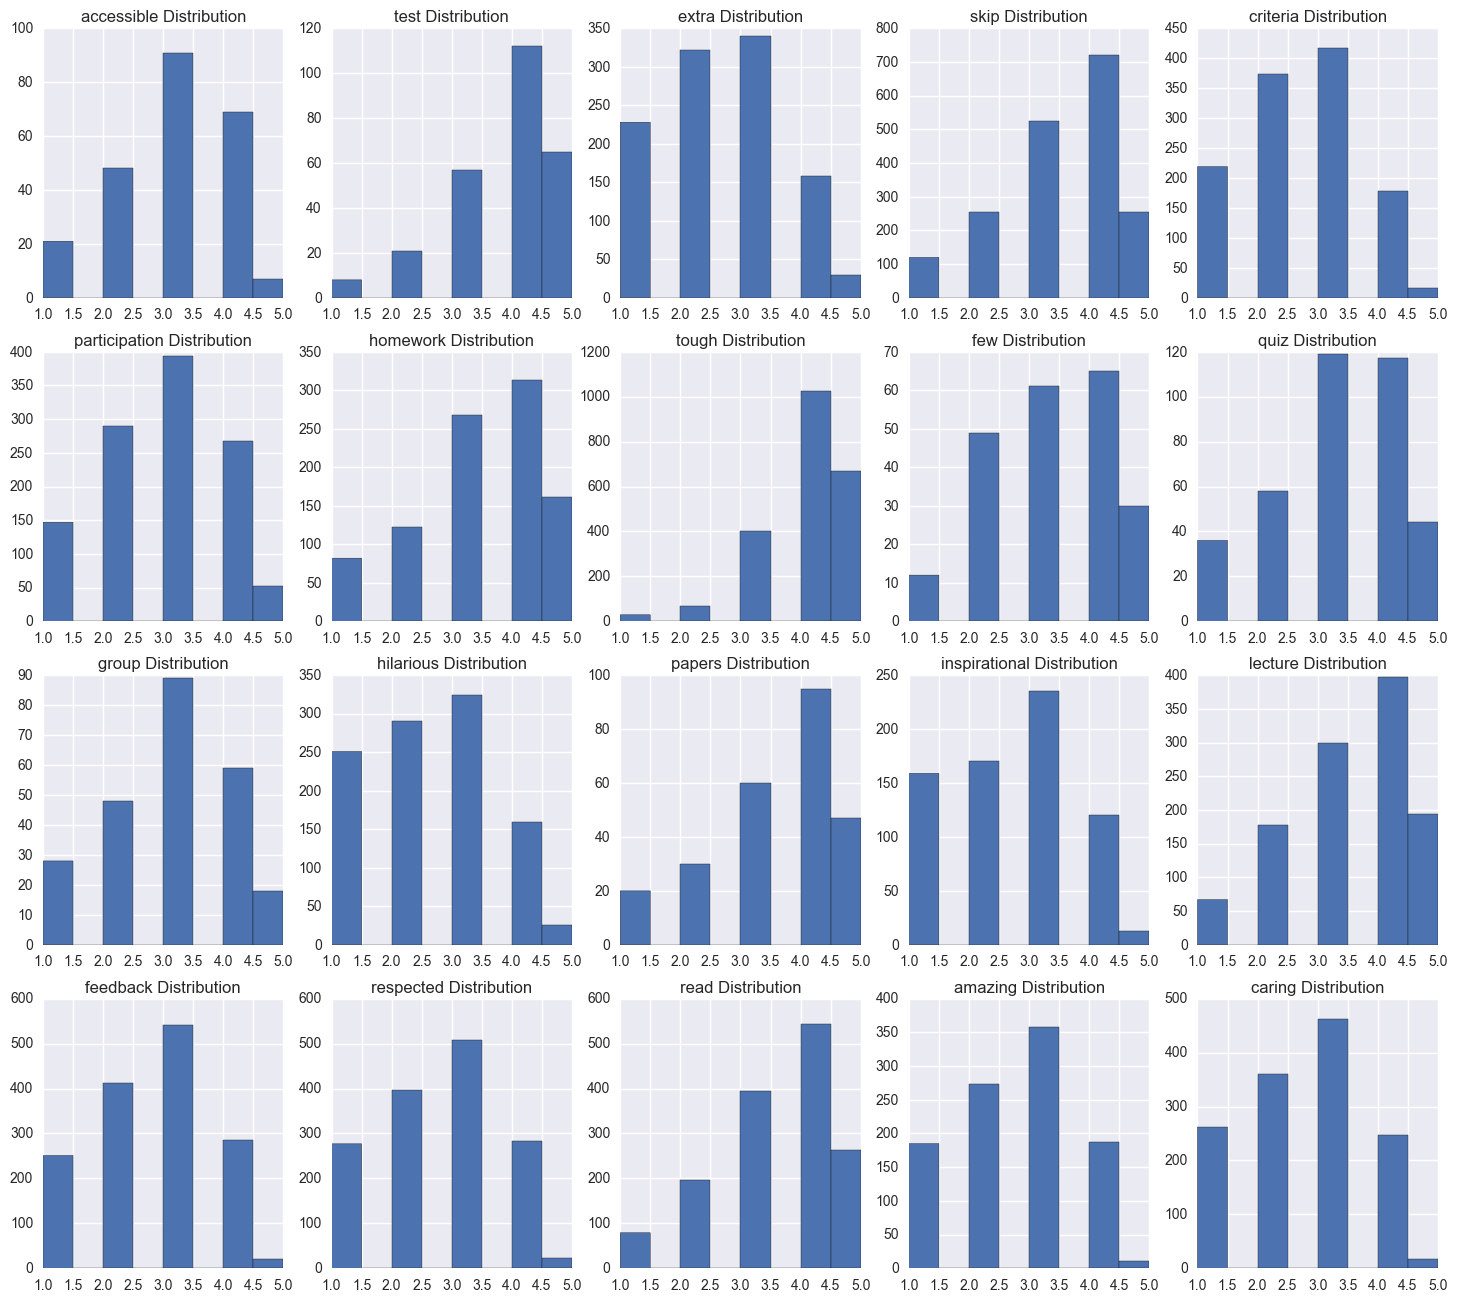

In [151]:
# same histograms but with difficulty -- note that this is much less clear in terms of indicators predicting score
draw_histograms_indic(review_df, 'difficulty',keywords, 4, 5)

In [ ]:
# plot counts of men vs. women for all of these different indicator variables

In [ ]:
# then need to do a count of words